# CZ gate in Rydberg atoms

$$H = \frac{\Omega(t)}{2}\left[e^{i\phi(t)} (\sigma_+^1 + \sigma_+^2) +  e^{-i\phi(t)} (\sigma_-^1+\sigma_-^2)\right] - \Delta(t) (n_1 + n_2) + V n_1n_2$$

see [Levine et al.](https://arxiv.org/pdf/1908.06101.pdf)

In [1]:
using Sisyphus
using QuantumOptics
using Flux, DiffEqFlux
using Plots
using Random
using ProgressMeter

ProgressMeter.ijulia_behavior(:clear);

In [2]:
V = 2π*10.0; # MHz

In [3]:
bs = NLevelBasis(3)
bsys = bs⊗bs

id = identityoperator(bs)

sp1 = transition(bs, 3, 2)⊗id
sm1 = transition(bs, 2, 3)⊗id

sp2 = id⊗transition(bs, 3, 2)
sm2 = id⊗transition(bs, 2, 3)

n1 = transition(bs, 3, 3)⊗id
n2 = id⊗transition(bs, 3, 3);

In [4]:
H0 = V*(n1*n2)
H1 = (n1 + n2)
H2 = (sp1 + sp2 + sm1 + sm2)
H3 = 1.0im*(sp1 + sp2 - sm1 - sm2);

In [5]:
states= [nlevelstate(bs, 1)⊗nlevelstate(bs, 1),
         nlevelstate(bs, 1)⊗nlevelstate(bs, 2),
         nlevelstate(bs, 2)⊗nlevelstate(bs, 1),
         nlevelstate(bs, 2)⊗nlevelstate(bs, 2)]

trans = UnitaryTransform(states, [[1.0 0 0 0 ];[0 1.0 0 0 ];[0 0 1.0 0 ]; [0 0 0 -1.0]]);

In [6]:
n_neurons = 4
ann = FastChain(FastDense(1, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, n_neurons, tanh), 
                FastDense(n_neurons, 3))
θ = initial_params(ann)     
n_params = length(θ);
Random.seed!(3)
θ = 2.0*rand(n_params).-1.0;

In [7]:
t0, t1 = 0.0, 1.0
sigmoid(x)= @. 2π*7 / (1 + exp(-x))
coeffs(p, t) = let vals = ann([t], p)
                [-vals[1], sigmoid(vals[2])*cos(vals[3]), sigmoid(vals[2])*sin(vals[3])]
               end    
cost = CostFunction((x, y) -> 1.0-real(x'*y),
                     p->2e-2*(sigmoid(ann([t0], p)[2])^2 + sigmoid(ann([t1], p)[2])^2))

H = Hamiltonian(H0, [H1, H2, H3], coeffs)
prob = QOCProblem(H, trans, (t0, t1), cost);

In [8]:
sol = solve(prob, θ, ADAM(0.008); maxiter=2000, abstol=1e-6, reltol=1e-6);

Progress: 100%|█████████████████████████████████████████| Time: 0:15:37
  distance:     0.0018210702524238953
  constraints:  0.015069570351528385


In [9]:
cost.constraints = p->(sigmoid(ann([t0], p)[2])^2 + sigmoid(ann([t1], p)[2])^2)
sol1 = solve(prob, sol.params, ADAM(0.008); maxiter=500, abstol=1e-6, reltol=1e-6);

Progress: 100%|█████████████████████████████████████████| Time: 0:03:45
  distance:     0.006063003962643532
  constraints:  0.012359362552093491


In [10]:
Ω(t) = sigmoid(ann([t], sol1.params)[2])/2π
Δ(t) = -ann([t], sol1.params)[1]/2π
ϕ(t) = ann([t], sol1.params)[3];

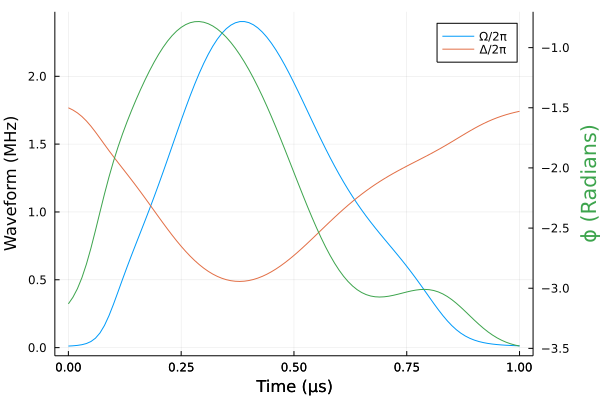

In [11]:
green = theme_palette(:auto).colors.colors[3]

ts = collect(t0:t1/100:t1)
plot(ts, Ω.(ts), label="Ω/2π")
plot!(ts, Δ.(ts), label="Δ/2π")
ylabel!("Waveform (MHz)")
plot!(Plots.twinx(), ts, ϕ.(ts), ylabel="ϕ (Radians)", color=green,
      yguidefont = font(green), legend=false)
xlabel!("Time (µs)", right_margin = 15Plots.mm)

In [12]:
tout, psit22 = schroedinger_dynamic(ts, nlevelstate(bs, 2)⊗nlevelstate(bs, 2),
                                    H, sol1.params)
tout, psit21 = schroedinger_dynamic(ts, nlevelstate(bs, 2)⊗nlevelstate(bs, 1),
                                    H, sol1.params)
tout, psit12 = schroedinger_dynamic(ts, nlevelstate(bs, 1)⊗nlevelstate(bs, 2),
                                    H, sol1.params)
tout, psit11 = schroedinger_dynamic(ts, nlevelstate(bs, 1)⊗nlevelstate(bs, 1),
                                    H, sol1.params);

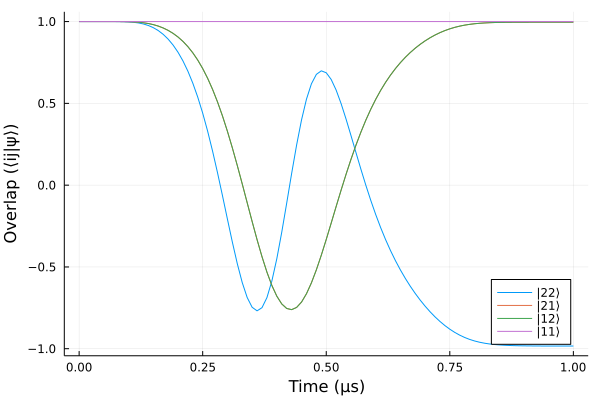

In [13]:
plot(tout, [real((nlevelstate(bs, 2)⊗nlevelstate(bs, 2))'*elm) for elm in psit22], label="|22⟩")
plot!(tout, [real((nlevelstate(bs, 2)⊗nlevelstate(bs, 1))'*elm) for elm in psit21], label="|21⟩")
plot!(tout, [real((nlevelstate(bs, 1)⊗nlevelstate(bs, 2))'*elm) for elm in psit12], label="|12⟩")
plot!(tout, [real((nlevelstate(bs, 1)⊗nlevelstate(bs, 1))'*elm) for elm in psit11], label="|11⟩", legend=:bottomright)        
xlabel!("Time (µs)")
ylabel!("Overlap (⟨ij|ψ⟩)")